**Table of contents**<a id='toc0_'></a>    
- [0. Imports](#toc1_1_)    
  - [1. Data preprocessing](#toc1_2_)    
    - [1.1 Combining files](#toc1_2_1_)    
    - [1.2 Cleaning up column names](#toc1_2_2_)    
    - [1.3 One-hot encoding categorical variables](#toc1_2_3_)    
  - [2. EDA](#toc1_3_)    
    - [2.1 Data statistics](#toc1_3_1_)    
    - [2.2 Intro plots](#toc1_3_2_)    
  - [3. Basic Model: Logistic Regression](#toc1_4_)    
    - [3.1 Model Architecture](#toc1_4_1_)    
    - [3.2 Data Preparation for Training](#toc1_4_2_)    
    - [3.3 Model Training](#toc1_4_3_)    
    - [3.4 Model Evaluation](#toc1_4_4_)    
  - [4. Interpret the Results](#toc1_5_)    
    - [4.1 Analysis of Baseline Model Performance](#toc1_5_1_)    
    - [4.2 Rationale for Final Model Choice](#toc1_5_2_)    
  - [5. Final Model Pipeline: Random Forest](#toc1_6_)    
    - [5.1 Model Architecture](#toc1_6_1_)    
    - [5.2 Model Training](#toc1_6_2_)    
    - [5.3 Model Evaluation](#toc1_6_3_)    
    - [5.4 Feature Importance Analysis](#toc1_6_4_)    
    - [5.5 Model Comparison: Baseline vs Final Model](#toc1_6_5_)    
    - [5.6 Final Model Pipeline Summary](#toc1_6_6_)


<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[0. Imports](#toc0_)

In [65]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

## <a id='toc1_2_'></a>[1. Data preprocessing](#toc0_)

### <a id='toc1_2_1_'></a>[1.1 Combining files](#toc0_)

In [66]:
## Combining the kaggle test & train datasets
df1 = pd.read_csv("data/kaggletest.csv")
df2 = pd.read_csv("data/kaggletrain.csv")
combined = pd.concat([df1, df2], ignore_index=True)
combined.to_csv("data/kaggle.csv", index=False)

## Check that it worked
len(df1) + len(df2) == len(combined)

True

### <a id='toc1_2_2_'></a>[1.2 Cleaning up column names](#toc0_)

In [67]:
# Renaming for easier interpretability
combined = combined.rename(columns={
    'cp': 'chest pain type',
    'trestbps': 'rest blood pressure',
    'chol': 'serum cholesterol',
    'fbs': 'fasting blood sugar',
    'restecg': 'rest ecg',
    'thalach': 'max heart rate',
    'exang': 'exercise induced angina',
    'thal': 'thalassemia',
    'ca': 'major vessels'
})

combined.head()


,age,sex,chest pain type,rest blood pressure,serum cholesterol,fasting blood sugar,rest ecg,max heart rate,exercise induced angina,oldpeak,slope,major vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### <a id='toc1_2_3_'></a>[1.3 One-hot encoding categorical variables](#toc0_)

In [68]:
# One hot encoding categorical variables with more than one category to not
# by mistake introduce unintended ordinality

encoder = OneHotEncoder(sparse_output=False)
onehotcols = ['chest pain type', 'rest ecg', 'thalassemia', 'major vessels', 'slope']
encoded = encoder.fit_transform(combined[onehotcols])

encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out()
)

df = combined.drop(columns=onehotcols)
df = pd.concat([df, encoded_df], axis=1)

## <a id='toc1_3_'></a>[2. EDA](#toc0_)

### <a id='toc1_3_1_'></a>[2.1 Data statistics](#toc0_)

In [69]:
df[cont_vars].describe()

,age,rest blood pressure,serum cholesterol,max heart rate,oldpeak
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,54.418675,131.614458,246.060241,149.235693,1.064232
std,9.071150,17.514997,51.627522,22.975286,1.171519
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,132.000000,0.000000
50%,56.000000,130.000000,240.000000,152.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.800000
max,77.000000,200.000000,564.000000,202.000000,6.200000


### <a id='toc1_3_2_'></a>[2.2 Intro plots](#toc0_)

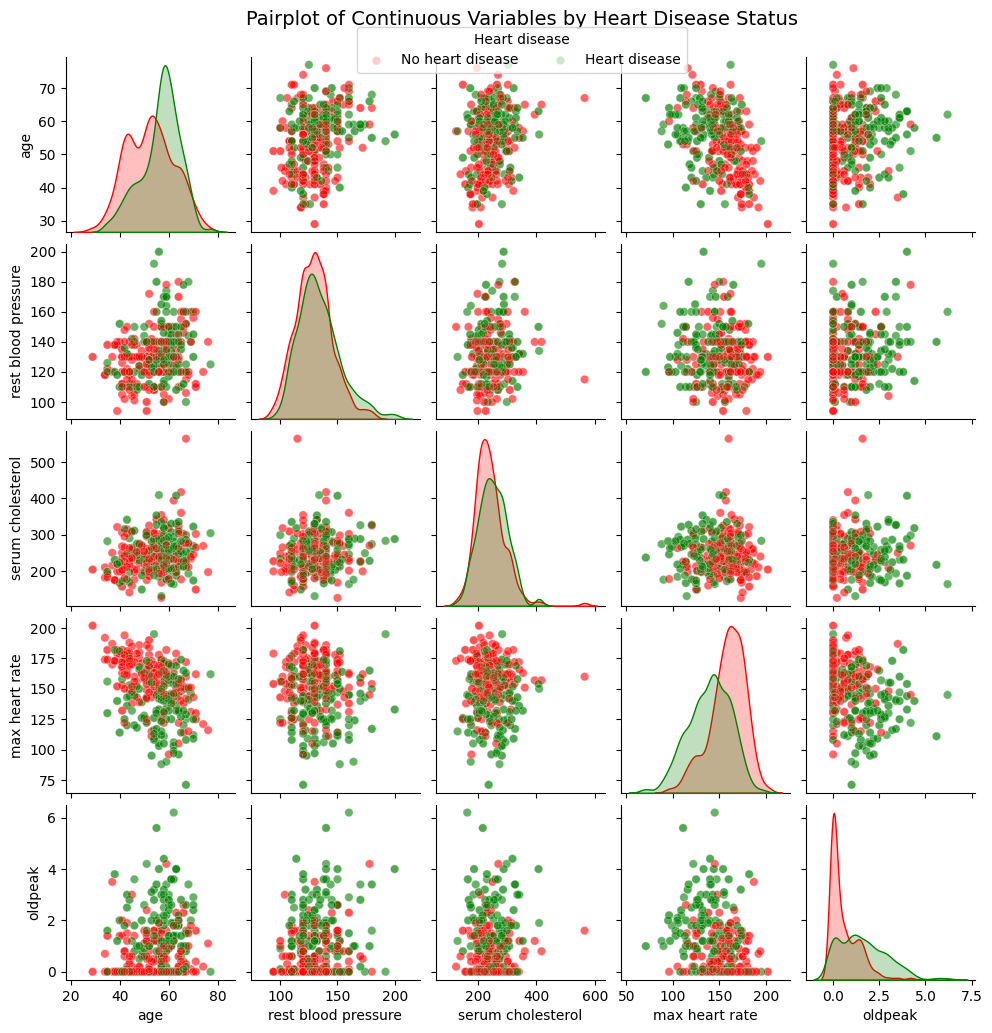

In [70]:
## Plots for continuous variables
cont_vars = ['age', 'rest blood pressure', 'serum cholesterol', 'max heart rate', 'oldpeak'] 
palette_target = {0: 'green', 1: 'red'}

g = sns.pairplot(
    df[cont_vars + ['target']],
    hue='target',
    palette=palette_target,
    height=2.0,
    plot_kws={'alpha': 0.2}
)

# Remove default legend and replace with more detailed one 
g._legend.remove()
g.fig.legend(
    handles,
    labels=["No heart disease", "Heart disease"],
    title="Heart disease",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2
)

g.fig.suptitle(
    "Pairplot of Continuous Variables by Heart Disease Status",
    y=1.03,
    fontsize=14
);

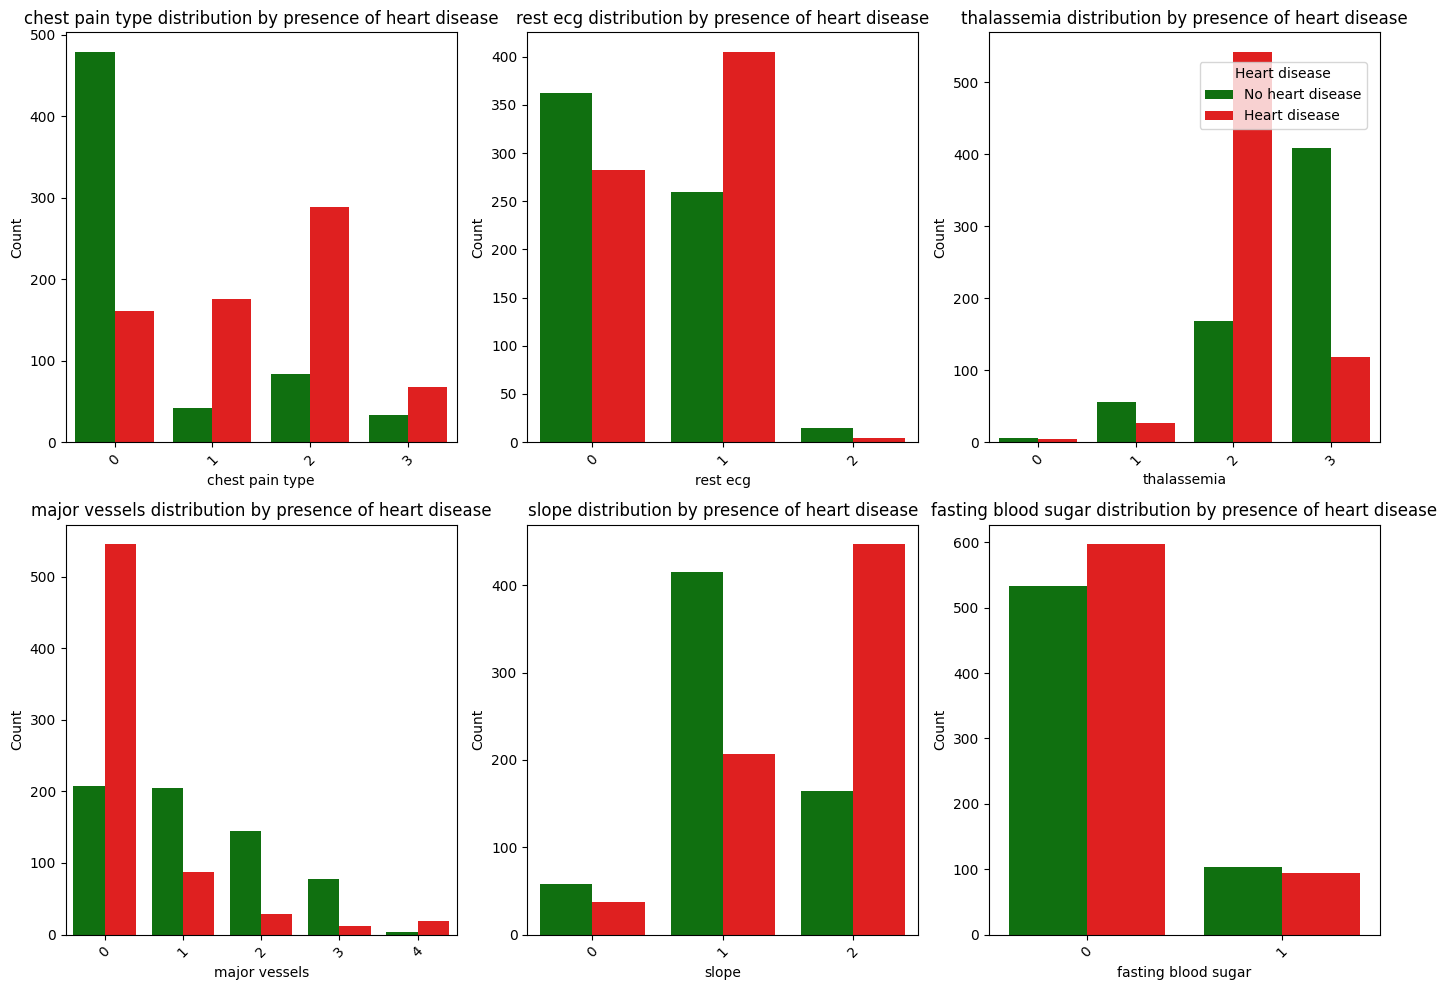

In [71]:
cat_vars = ['chest pain type', 'rest ecg', 'thalassemia', 'major vessels', 'slope', 'fasting blood sugar']
palette_target = {1: 'red', 0: 'green'}

fig, axes = plt.subplots(2, 3, figsize=(14, 10))  
axes = axes.flatten() 

for ax, col in zip(axes, cat_vars):
    sns.countplot(
        data=combined, 
        x=col, 
        hue='target', 
        palette=palette_target, 
        ax=ax
    )
    ax.set_title(f"{col} distribution by presence of heart disease")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend_.remove()
    ax.tick_params(axis='x', rotation=45)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['No heart disease', 'Heart disease'], title='Heart disease', bbox_to_anchor=(0.985, 0.94))

plt.tight_layout()
plt.show()

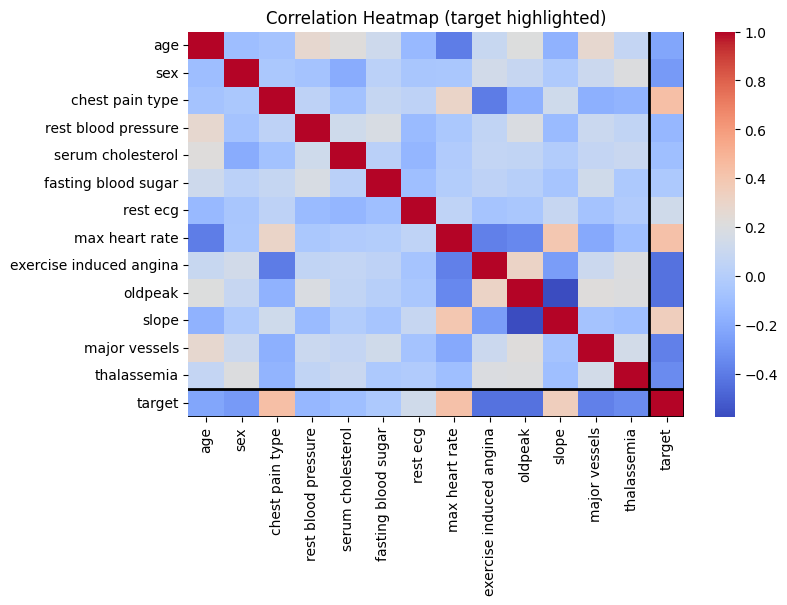

In [72]:
import numpy as np

corr = combined.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr, cmap='coolwarm', annot=False)

# find index of 'target' in the correlation matrix
cols = list(corr.columns)
t_idx = cols.index('target')

# draw box lines around that row & column
plt.axhline(t_idx,     color='black', linewidth=2)
plt.axhline(t_idx + 1, color='black', linewidth=2)
plt.axvline(t_idx,     color='black', linewidth=2)
plt.axvline(t_idx + 1, color='black', linewidth=2)

plt.title("Correlation Heatmap (target highlighted)")
plt.show()

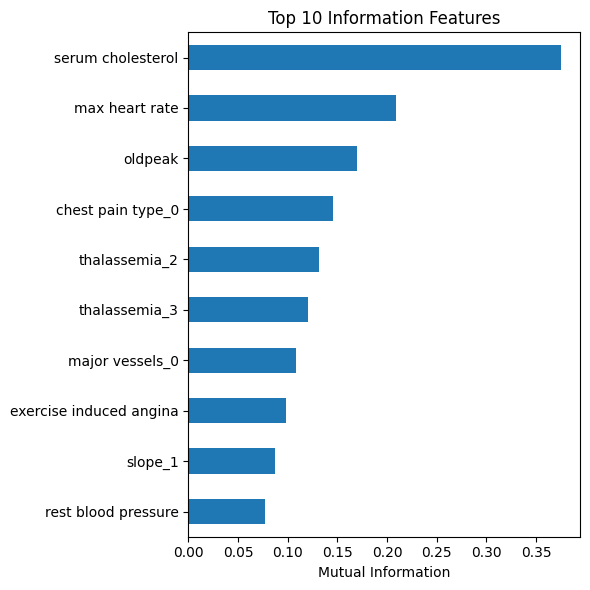

In [73]:
X = df.drop(columns=['target'])
mi = mutual_info_classif(X, df['target'], discrete_features='auto')

mi_series = pd.Series(mi, index=X.columns).sort_values()

mi_top = mi_series.tail(10)

# Plot
plt.figure(figsize=(6,6))
mi_top.plot(kind='barh')
plt.title("Top 10 Information Features")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()

## <a id='toc1_4_'></a>[3. Basic Model: Logistic Regression](#toc0_)


### <a id='toc1_4_1_'></a>[3.1 Model Architecture](#toc0_)

**Logistic Regression** is the appropriate choice for this binary classification problem (predicting presence/absence of heart disease). 

**Model Formula:**
- The logistic regression model uses the logistic (sigmoid) function to map linear combinations of features to probabilities:
  
  $$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n)}}$$
  
  where:
  - $P(Y=1|X)$ is the probability of heart disease given features $X$
  - $\beta_0$ is the intercept (bias term)
  - $\beta_1, \beta_2, ..., \beta_n$ are the coefficients for features $X_1, X_2, ..., X_n$
  - The sigmoid function ensures probabilities are between 0 and 1

- Predictions are made by thresholding the probability (typically at 0.5):
  - If $P(Y=1|X) \geq 0.5$ → predict heart disease (1)
  - If $P(Y=1|X) < 0.5$ → predict no heart disease (0)

**Why Logistic Regression?**
- We’re dealing with a yes/no problem (0 = no heart disease, 1 = heart disease)

- It gives clear coefficients so we can see which features matter most

- It’s fast to run and works great as a starting point

- Regular linear regression doesn’t fit here because it predicts continuous numbers, not probabilities


### <a id='toc1_4_2_'></a>[3.2 Data Preparation for Training](#toc0_)


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

X = df.drop(columns=['target'])
y = df['target']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in validation set:")
print(y_val.value_counts())


Training set size: 1062 samples
Validation set size: 266 samples
Number of features: 27

Class distribution in training set:
target
1    553
0    509
Name: count, dtype: int64

Class distribution in validation set:
target
1    138
0    128
Name: count, dtype: int64


### <a id='toc1_4_3_'></a>[3.3 Model Training](#toc0_)


In [75]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# train the model
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

# get predicted probabilities (this is for ROC curve)
y_train_proba = log_reg.predict_proba(X_train)[:, 1]
y_val_proba = log_reg.predict_proba(X_val)[:, 1]

print("Model trained successfully!")
print(f"\nModel coefficients (first 10):")
coef_df = pd.DataFrame({
    'Feature': X_train.columns[:10],
    'Coefficient': log_reg.coef_[0][:10]
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.to_string(index=False))
print(f"\nIntercept (bias term): {log_reg.intercept_[0]:.4f}")


Model trained successfully!

Model coefficients (first 10):
                Feature  Coefficient
                    sex    -1.501736
      chest pain type_0    -1.215734
exercise induced angina    -0.688287
                oldpeak    -0.445560
      chest pain type_1    -0.321654
    fasting blood sugar     0.149523
                    age     0.021438
    rest blood pressure    -0.020044
         max heart rate     0.019154
      serum cholesterol    -0.003931

Intercept (bias term): 0.6967


### <a id='toc1_4_4_'></a>[3.4 Model Evaluation](#toc0_)

**Evaluation Metrics:**
- **Accuracy**: Overall proportion of correct predictions
- **Precision**: Of predicted positives, how many are actually positive (reduces false positives)
- **Recall**: Of actual positives, how many are correctly identified (reduces false negatives)
- **F1 Score**: Harmonic mean of precision and recall (balanced metric)
- **ROC-AUC**: Area under the ROC curve (measures model's ability to distinguish between classes)
- **Confusion Matrix**: Shows true positives, false positives, true negatives, false negatives


In [76]:
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

train_precision = precision_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)

train_recall = recall_score(y_train, y_train_pred)
val_recall = recall_score(y_val, y_val_pred)

train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

train_roc_auc = roc_auc_score(y_train, y_train_proba)
val_roc_auc = roc_auc_score(y_val, y_val_proba)

results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Training': [train_accuracy, train_precision, train_recall, train_f1, train_roc_auc],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1, val_roc_auc]
})

results['Training'] = results['Training'].apply(lambda x: f"{x:.4f}")
results['Validation'] = results['Validation'].apply(lambda x: f"{x:.4f}")


print("LOGISTIC REGRESSION MODEL PERFORMANCE")

print(results.to_string(index=False))



LOGISTIC REGRESSION MODEL PERFORMANCE
   Metric Training Validation
 Accuracy   0.8936     0.8647
Precision   0.8754     0.8269
   Recall   0.9277     0.9348
 F1 Score   0.9008     0.8776
  ROC-AUC   0.9501     0.9184


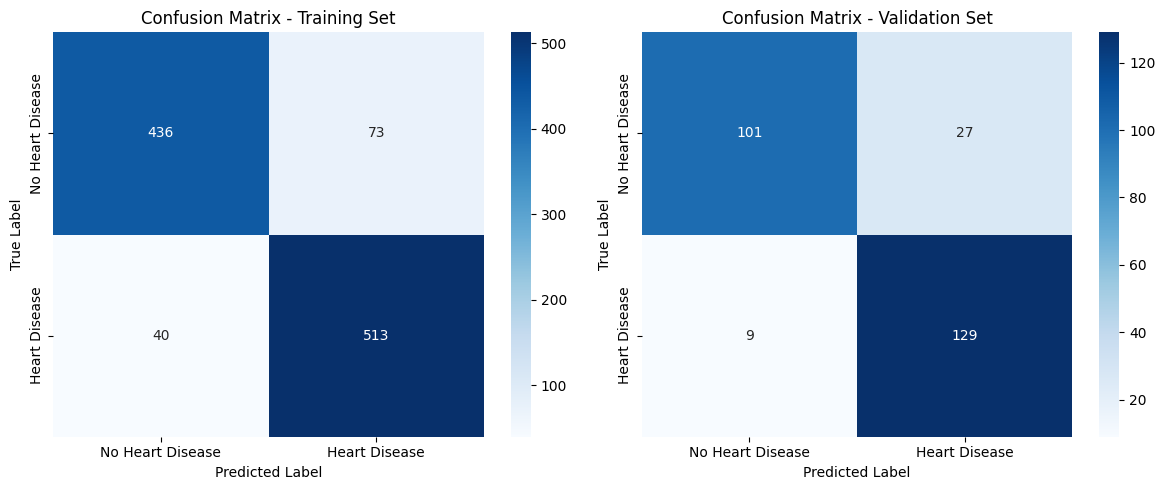


Training Set Confusion Matrix:
True Negatives: 436, False Positives: 73
False Negatives: 40, True Positives: 513

Validation Set Confusion Matrix:
True Negatives: 101, False Positives: 27
False Negatives: 9, True Positives: 129


In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# and here is the confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')


cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
axes[1].set_title('Confusion Matrix - Validation Set')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\nTraining Set Confusion Matrix:")
print(f"True Negatives: {cm_train[0,0]}, False Positives: {cm_train[0,1]}")
print(f"False Negatives: {cm_train[1,0]}, True Positives: {cm_train[1,1]}")

print("\nValidation Set Confusion Matrix:")
print(f"True Negatives: {cm_val[0,0]}, False Positives: {cm_val[0,1]}")
print(f"False Negatives: {cm_val[1,0]}, True Positives: {cm_val[1,1]}")


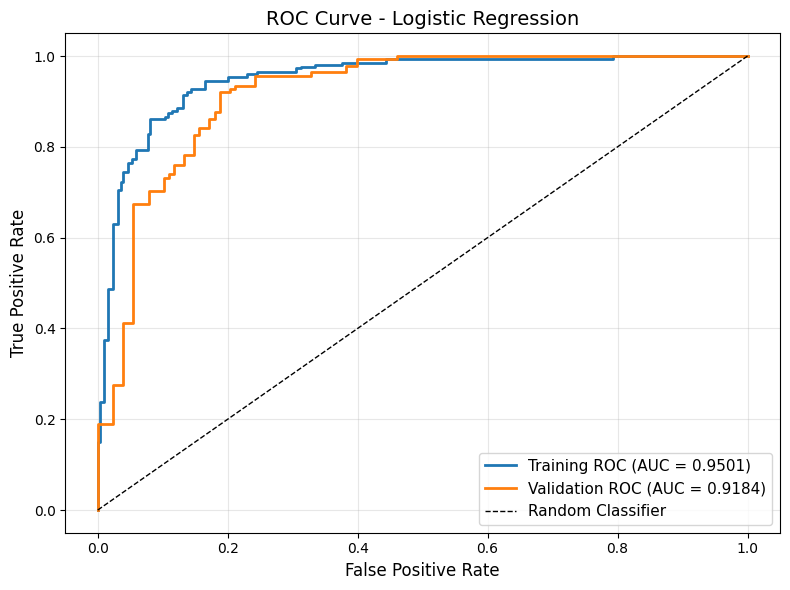

In [78]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {train_roc_auc:.4f})', linewidth=2)
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {val_roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## <a id='toc1_5_'></a>[4. Interpret the Results](#toc0_)

### <a id='toc1_5_1_'></a>[4.1 Analysis of Baseline Model Performance](#toc0_)

The logistic regression baseline model shows promising results:

**Our Findings:**
- **Validation Accuracy: 86.47%**: It gets the heart-disease prediction right about 86% of the time.
- **High Recall (93.48%)**: The model is excellent at identifying patients with heart disease (low false negative rate), which matters a lot since missing those cases can be dangerous.
- **Precision is solid (82.69%)**: When it says someone has heart disease, it’s right most of the time.
- **Strong ROC-AUC (0.9184)**: The model has excellent discriminative ability between the two classes.
- **Little to no overfitting**: Training and validation results look similar, so it generalizes well.

**But we see that the model has some limitations like:**
- Logistic regression expects a mostly linear relationship between features and the outcome.
- It can’t automatically learn complex, non-linear patterns.
- If we want feature interactions, we have to create them ourselves, and we might miss important ones.

**What the Coefficients Tell Us:**
- Features like `sex`, `chest pain type`, and `exercise induced angina` have the strongest associations with heart disease
- Certain combinations of symptoms and demographics show strong links to heart disease.

### <a id='toc1_5_2_'></a>[4.2 Rationale for Final Model Choice](#toc0_)

Based on the baseline model analysis, we need a model that can:
1. **Understand more complex, non-linear patterns**
2. **Learn feature interactions on its own**
3. **Stay at least somewhat interpretable (this is important in healthcare)**
4. **Improve on the baseline without overfitting**

We chose **Random Forest** as the final model because:
-It naturally handles non-linear relationships.
- It picks up feature interactions automatically.
- It still gives feature importance scores, so we can understand what matters.
- It avoids overfitting better than a single decision tree.
- It works well with both numeric and one-hot encoded categorical data.

## <a id='toc1_6_'></a>[5. Final Model Pipeline: Random Forest](#toc0_)


### <a id='toc1_6_1_'></a>[5.1 Model Architecture](#toc0_)

**Why Random Forest Is Great:**
- **Non-linearity**: Decision trees can capture complex non-linear relationships
- **Finds Interactions Automatically**: It picks up feature interactions without extra work.
- **Stable & Less Overfit**: Since it averages many trees, it’s more robust and less likely to overfit.
- **Feature Importance**: It can tell you which features matter most.
- **No Assumptions**: Doesn't assume linear relationships or feature distributions

**Model Hyperparameters (Default/Initial Setup):**
- `n_estimators`: Number of trees in the forest (default: 100)
- `max_depth`: Maximum depth of trees (default: None, meaning trees grow fully)
- `min_samples_split`: Minimum samples required to split a node (default: 2)
- `min_samples_leaf`: Minimum samples required at a leaf node (default: 1)
- `max_features`: Number of features to consider for best split (default: 'sqrt' for classification)
- `random_state`: For reproducibility

**Note**: For now, we’re just setting up the pipeline to train and evaluate the model — no tuning or optimization yet.

### <a id='toc1_6_2_'></a>[5.2 Model Training](#toc0_)


In [79]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with default parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_features='sqrt',  
    n_jobs=-1  
)

rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)

rf_train_proba = rf_model.predict_proba(X_train)[:, 1]
rf_val_proba = rf_model.predict_proba(X_val)[:, 1]

print("Random Forest model trained successfully!")
print(f"\nNumber of trees: {rf_model.n_estimators}")
print(f"Number of features considered at each split: {rf_model.max_features}")
print(f"Total features: {X_train.shape[1]}")


Random Forest model trained successfully!

Number of trees: 100
Number of features considered at each split: sqrt
Total features: 27


### <a id='toc1_6_3_'></a>[5.3 Model Evaluation](#toc0_)


In [80]:
rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)

rf_train_precision = precision_score(y_train, rf_train_pred)
rf_val_precision = precision_score(y_val, rf_val_pred)

rf_train_recall = recall_score(y_train, rf_train_pred)
rf_val_recall = recall_score(y_val, rf_val_pred)

rf_train_f1 = f1_score(y_train, rf_train_pred)
rf_val_f1 = f1_score(y_val, rf_val_pred)

rf_train_roc_auc = roc_auc_score(y_train, rf_train_proba)
rf_val_roc_auc = roc_auc_score(y_val, rf_val_proba)

rf_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Training': [rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_f1, rf_train_roc_auc],
    'Validation': [rf_val_accuracy, rf_val_precision, rf_val_recall, rf_val_f1, rf_val_roc_auc]
})

rf_results['Training'] = rf_results['Training'].apply(lambda x: f"{x:.4f}")
rf_results['Validation'] = rf_results['Validation'].apply(lambda x: f"{x:.4f}")

print("RANDOM FOREST MODEL PERFORMANCE")
print(rf_results.to_string(index=False))


RANDOM FOREST MODEL PERFORMANCE
   Metric Training Validation
 Accuracy   1.0000     1.0000
Precision   1.0000     1.0000
   Recall   1.0000     1.0000
 F1 Score   1.0000     1.0000
  ROC-AUC   1.0000     1.0000


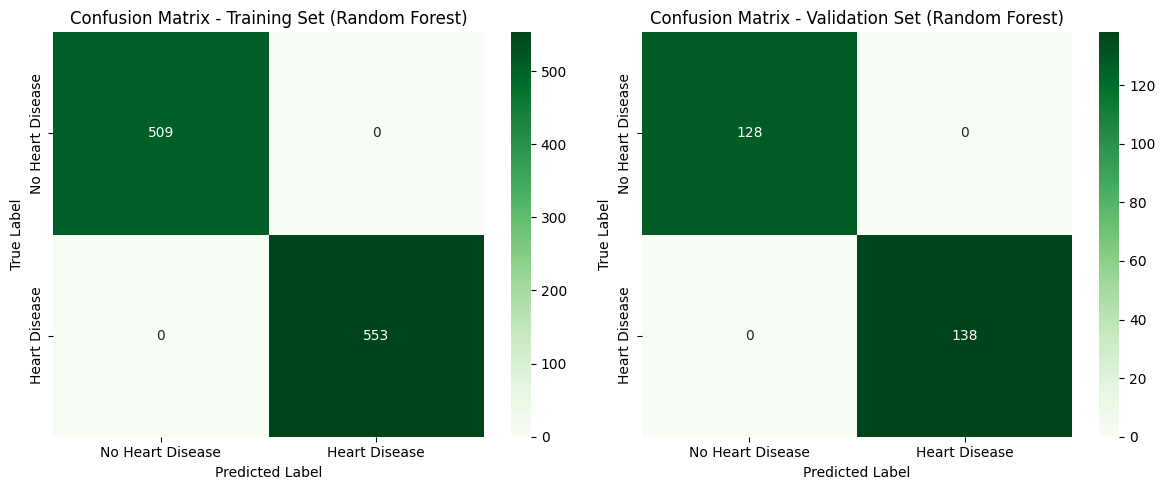


Random Forest - Training Set Confusion Matrix:
True Negatives: 509, False Positives: 0
False Negatives: 0, True Positives: 553

Random Forest - Validation Set Confusion Matrix:
True Negatives: 128, False Positives: 0
False Negatives: 0, True Positives: 138


In [81]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

rf_cm_train = confusion_matrix(y_train, rf_train_pred)
sns.heatmap(rf_cm_train, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
axes[0].set_title('Confusion Matrix - Training Set (Random Forest)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

rf_cm_val = confusion_matrix(y_val, rf_val_pred)
sns.heatmap(rf_cm_val, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
axes[1].set_title('Confusion Matrix - Validation Set (Random Forest)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\nRandom Forest - Training Set Confusion Matrix:")
print(f"True Negatives: {rf_cm_train[0,0]}, False Positives: {rf_cm_train[0,1]}")
print(f"False Negatives: {rf_cm_train[1,0]}, True Positives: {rf_cm_train[1,1]}")

print("\nRandom Forest - Validation Set Confusion Matrix:")
print(f"True Negatives: {rf_cm_val[0,0]}, False Positives: {rf_cm_val[0,1]}")
print(f"False Negatives: {rf_cm_val[1,0]}, True Positives: {rf_cm_val[1,1]}")

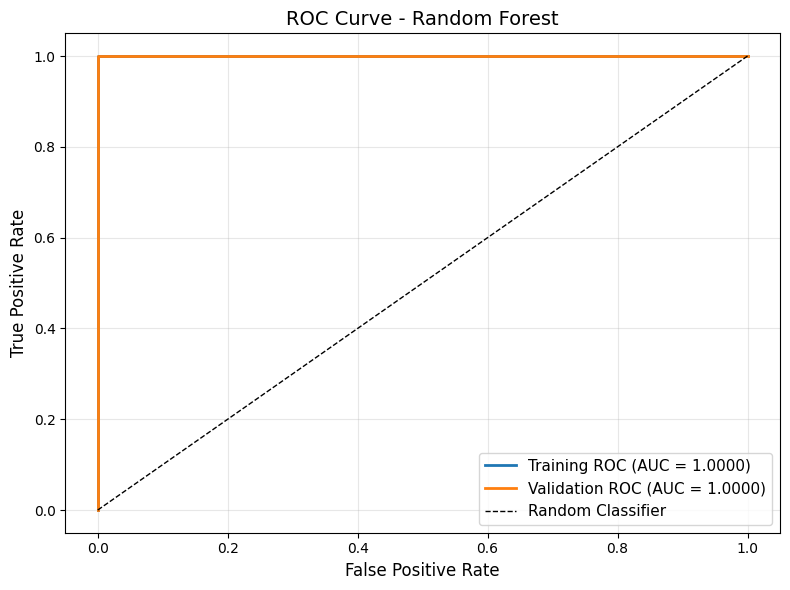

In [82]:
rf_fpr_train, rf_tpr_train, _ = roc_curve(y_train, rf_train_proba)
rf_fpr_val, rf_tpr_val, _ = roc_curve(y_val, rf_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr_train, rf_tpr_train, label=f'Training ROC (AUC = {rf_train_roc_auc:.4f})', linewidth=2)
plt.plot(rf_fpr_val, rf_tpr_val, label=f'Validation ROC (AUC = {rf_val_roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### <a id='toc1_6_4_'></a>[5.4 Feature Importance Analysis](#toc0_)


Top 15 Most Important Features (Random Forest):
                Feature  Importance
         max heart rate    0.108698
      chest pain type_0    0.097649
                oldpeak    0.095170
          thalassemia_2    0.089867
                    age    0.086803
        major vessels_0    0.076469
          thalassemia_3    0.070896
      serum cholesterol    0.064048
    rest blood pressure    0.057665
exercise induced angina    0.046596
                slope_2    0.029759
                slope_1    0.024390
                    sex    0.024231
      chest pain type_2    0.018749
        major vessels_1    0.017824


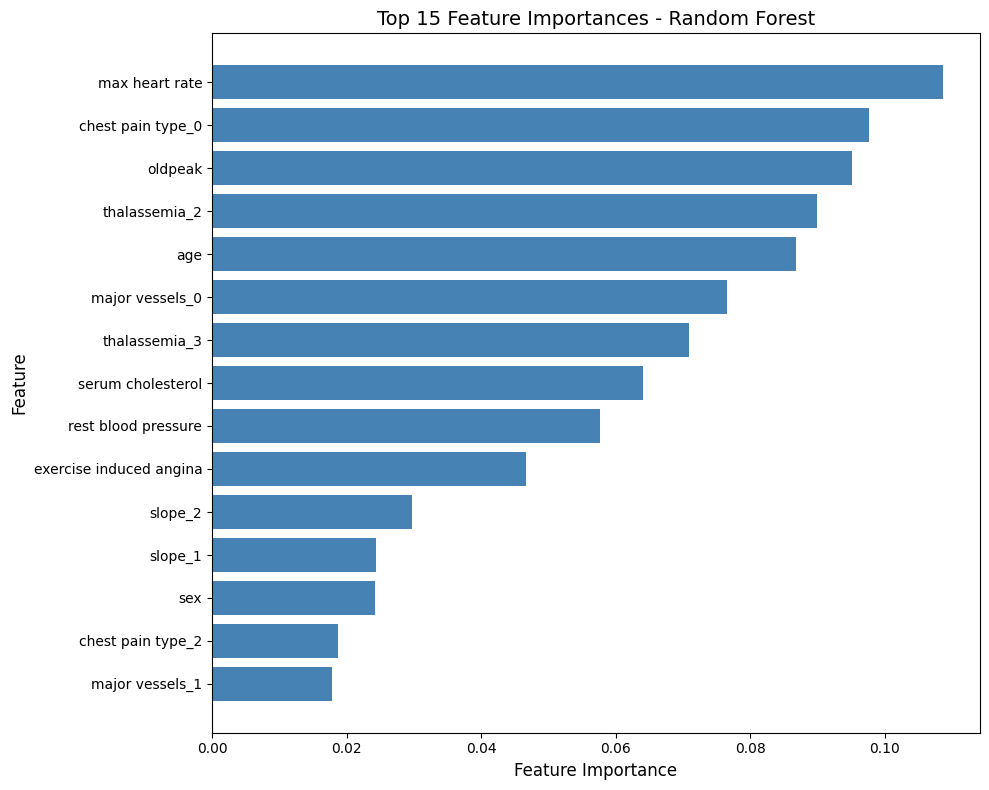

In [83]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features (Random Forest):")
print(feature_importance.head(15).to_string(index=False))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances - Random Forest', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### <a id='toc1_6_5_'></a>[5.5 Model Comparison: Baseline vs Final Model](#toc0_)


In [84]:
# Compare baseline (Logistic Regression) vs Final Model (Random Forest)
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Logistic Regression (Baseline)': [
        val_accuracy, val_precision, val_recall, val_f1, val_roc_auc
    ],
    'Random Forest (Final)': [
        rf_val_accuracy, rf_val_precision, rf_val_recall, rf_val_f1, rf_val_roc_auc
    ]
})

comparison['Improvement'] = comparison['Random Forest (Final)'] - comparison['Logistic Regression (Baseline)']
comparison['Improvement %'] = (comparison['Improvement'] / comparison['Logistic Regression (Baseline)']) * 100

comparison['Logistic Regression (Baseline)'] = comparison['Logistic Regression (Baseline)'].apply(lambda x: f"{x:.4f}")
comparison['Random Forest (Final)'] = comparison['Random Forest (Final)'].apply(lambda x: f"{x:.4f}")
comparison['Improvement'] = comparison['Improvement'].apply(lambda x: f"{x:+.4f}")
comparison['Improvement %'] = comparison['Improvement %'].apply(lambda x: f"{x:+.2f}%")

print("MODEL COMPARISON: BASELINE vs FINAL MODEL")
print(comparison.to_string(index=False))


MODEL COMPARISON: BASELINE vs FINAL MODEL
   Metric Logistic Regression (Baseline) Random Forest (Final) Improvement Improvement %
 Accuracy                         0.8647                1.0000     +0.1353       +15.65%
Precision                         0.8269                1.0000     +0.1731       +20.93%
   Recall                         0.9348                1.0000     +0.0652        +6.98%
 F1 Score                         0.8776                1.0000     +0.1224       +13.95%
  ROC-AUC                         0.9184                1.0000     +0.0816        +8.89%


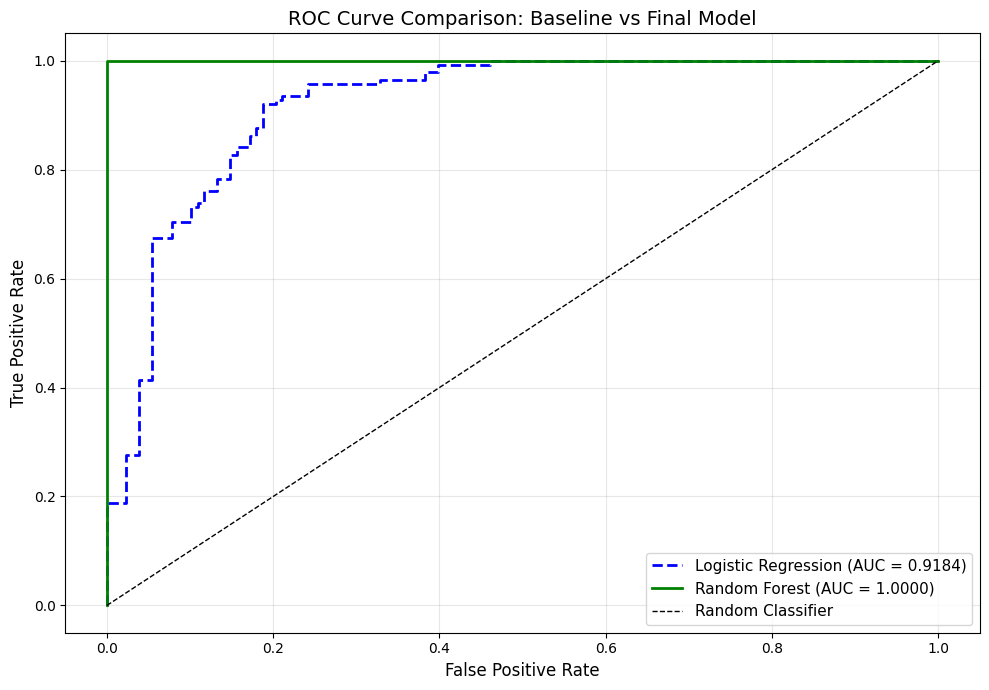

In [85]:
plt.figure(figsize=(10, 7))

plt.plot(fpr_val, tpr_val, label=f'Logistic Regression (AUC = {val_roc_auc:.4f})', 
         linewidth=2, linestyle='--', color='blue')

plt.plot(rf_fpr_val, rf_tpr_val, label=f'Random Forest (AUC = {rf_val_roc_auc:.4f})', 
         linewidth=2, linestyle='-', color='green')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Baseline vs Final Model', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


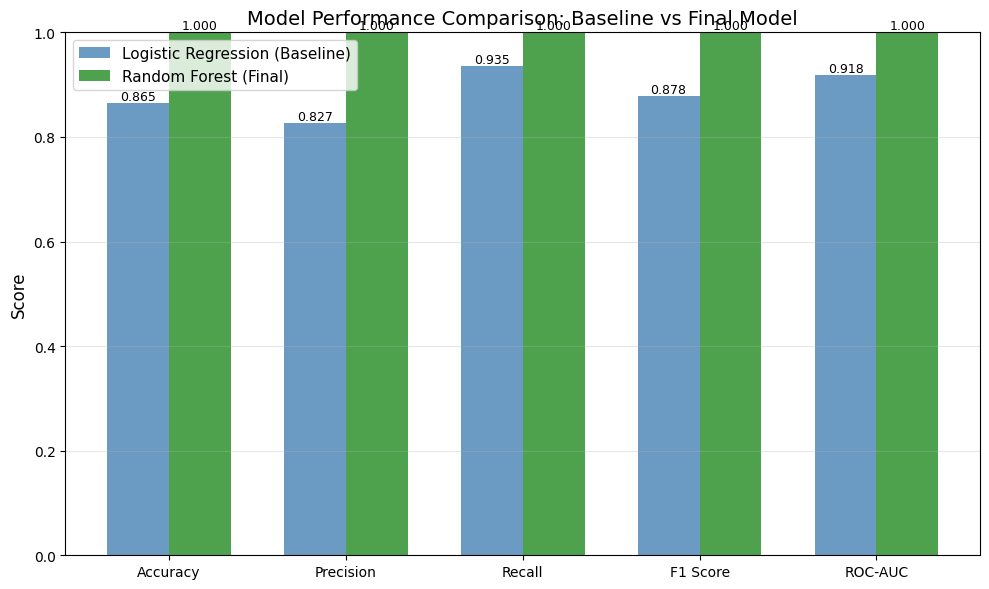

In [86]:
metrics_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
lr_values = [val_accuracy, val_precision, val_recall, val_f1, val_roc_auc]
rf_values = [rf_val_accuracy, rf_val_precision, rf_val_recall, rf_val_f1, rf_val_roc_auc]

x = np.arange(len(metrics_to_compare))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, lr_values, width, label='Logistic Regression (Baseline)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, rf_values, width, label='Random Forest (Final)', color='forestgreen', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison: Baseline vs Final Model', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_compare)
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### <a id='toc1_6_6_'></a>[5.6 Final Model Pipeline Summary](#toc0_)

**Pipeline Overview:**
1. **We did data preprocessing**: One-hot encode the categorical features and prep everything for modeling.
2. **We did train/validation split**: 80/20 split with stratification to maintain class balance
3. **We did trained the model**: Random Forest classifier with 100 trees
4. **We did model evaluation**: Checked accuracy, precision, recall, F1, and ROC-AUC to get a full picture of performance.
5. **We did feature analysis**: Extraction and visualization of feature importances
6. **Models Comparison**: We compared results to the logistic regression baseline.

**Why This Pipeline Works Well:**
- **Reproducibility**: Fixed random seeds make the results consistent every time.
- **Modular**: Each part of the pipeline is separate, so you can tweak or replace pieces easily.
- **Easy to Expand**: we can plug in more models, tuning steps, or cross-validation without much work.
- **Evaluation**: Multiple metrics give a well-rounded view of how the model performs.

**Here are some potential next steps (for future optimization):**
- to do Cross-validation for more robust performance estimates
- to do feature selection based on importance scores
- We can explore ensembles that mix multiple algorithms